In [1]:
import os
import glob
from datetime import datetime
import pandas as pd
from huggingface_hub import snapshot_download, hf_hub_download
from terratorch.datamodules import HelioNetCDFDataModule
from terratorch.registry import BACKBONE_REGISTRY
from terratorch.tasks import InferenceTask
import matplotlib.pyplot as plt
import lightning.pytorch as pl
import torch
import time

/dccstor/jlsa931/envs/terratorch/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
if not os.path.isdir("experiment"):
    os.mkdir("experiment")

root_dir = "experiment"

# Downloading validation data
snapshot_download(repo_id="nasa-ibm-ai4science/Surya-1.0_validation_data",
                  repo_type="dataset", local_dir=root_dir)

# Downloading scalers file
hf_hub_download(repo_id="nasa-ibm-ai4science/Surya-1.0",
                  filename="scalers.yaml", local_dir=root_dir)

# Creating index file
sample_files = glob.glob(os.path.join(root_dir,"*.nc"))
paths = sorted(sample_files)
present = len(paths)*[1]

timestamps  = []
for ff in paths:
    filename = os.path.basename(ff).replace(".nc", "")
    date, timestamp = filename.split("_")

    year = int(date[:4])
    month = int(date[4:6])
    day = int(date[6:])
    hour = int(timestamp[:2])
    minutes = int(timestamp[2:])
    seconds = 0

    date_datetime = datetime(year, month, day, hour, minutes,
                             seconds).strftime("%Y-%m-%d %H:%M:%S")


    timestamps.append(date_datetime)

index_dict = {"path": paths, "timestep": timestamps, "present": present}
index_dataframe = pd.DataFrame(index_dict)
index_dataframe.to_csv(os.path.join(root_dir, "index.csv"))
index_path = os.path.join(root_dir, "index.csv")
scalers_path = os.path.join(root_dir, "scalers.yaml")

Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

In [3]:
channels = ['aia94', 'aia131', 'aia171', 'aia193', 'aia211', 'aia304',
        'aia335', 'aia1600', 'hmi_m', 'hmi_bx', 'hmi_by', 'hmi_bz', 'hmi_v']

In [4]:
model_name = "heliofm_backbone_surya"
backbone = BACKBONE_REGISTRY.build(model_name, pretrained=True)

In [5]:
datamodule = HelioNetCDFDataModule(
        train_index_path=index_path,
        test_index_path=index_path,
        val_index_path=index_path,
        predict_index_path=index_path,
        batch_size=1,
        num_workers=0,
        time_delta_input_minutes=[-60,0] ,
        time_delta_target_minutes=+60,
        channels = channels,
        n_input_timestamps=2,
        rollout_steps=1,
        scalers=scalers_path)

In [6]:
datamodule.setup("predict")

In [7]:
model = InferenceTask(model=backbone) 

/dccstor/jlsa931/envs/terratorch/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
freeze_backbone and freeze_decoder are ignored if a custom model is provided.


In [8]:
pl.seed_everything(0)

# Lightning Trainer
trainer = pl.Trainer(
    accelerator="gpu",
    strategy="auto",
    devices=1, 
    #precision='bf16-mixed',
    num_nodes=1,
    logger=True,
    max_epochs=1,
    log_every_n_steps=1,
    enable_checkpointing=True,
    callbacks=[pl.callbacks.RichProgressBar()],
    default_root_dir="output/heliofm",
)

Seed set to 0


Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.


GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [9]:
start_time = time.time()
prediction = trainer.predict(model, datamodule=datamodule)
print(f"Evaluation time {time.time() - start_time} s.")

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/dccstor/jlsa931/envs/terratorch/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Evaluation time 3407.170008420944 s.


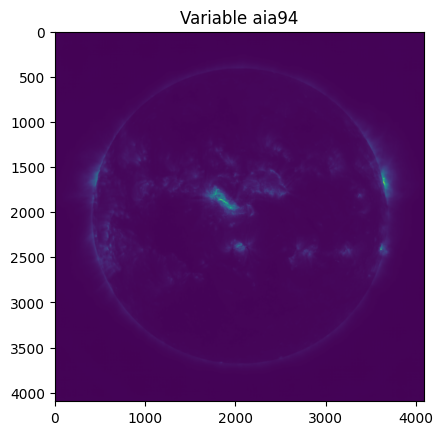

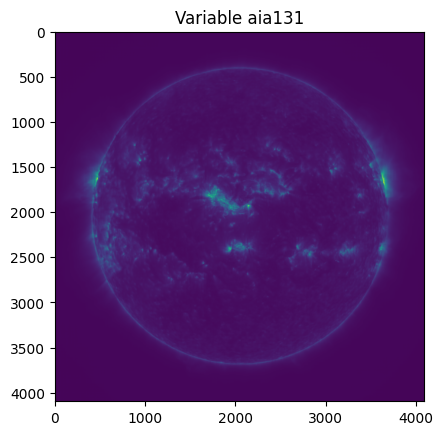

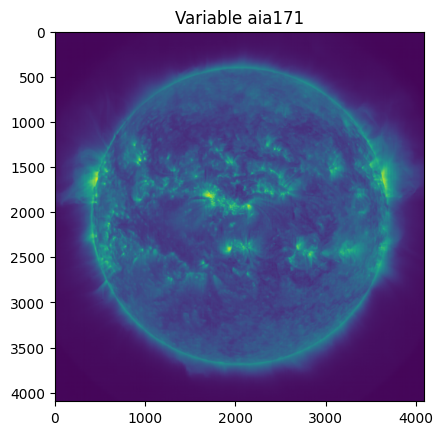

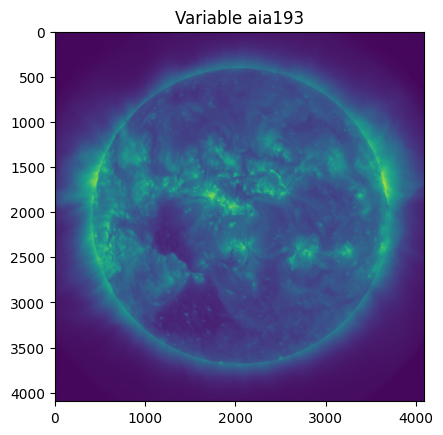

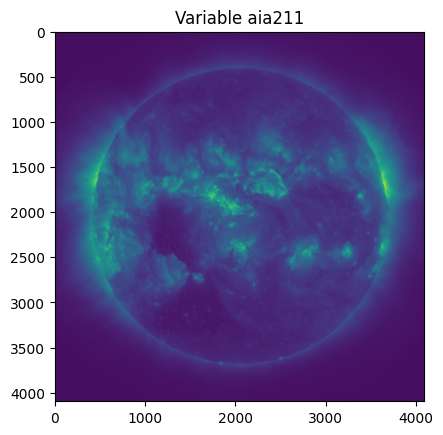

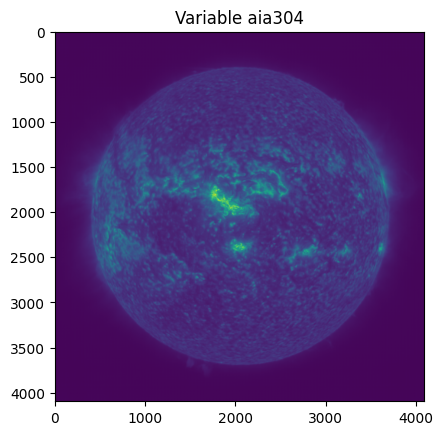

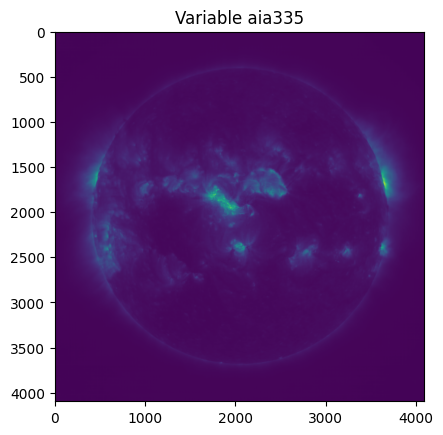

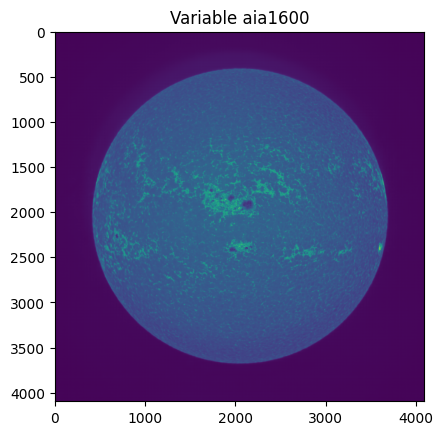

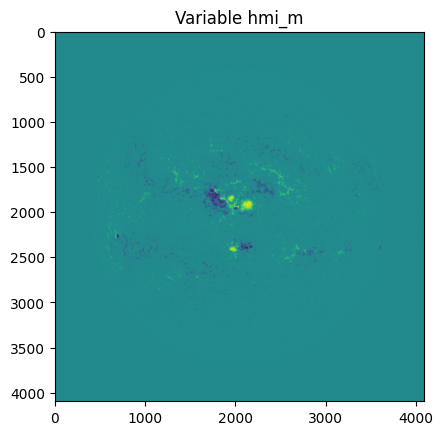

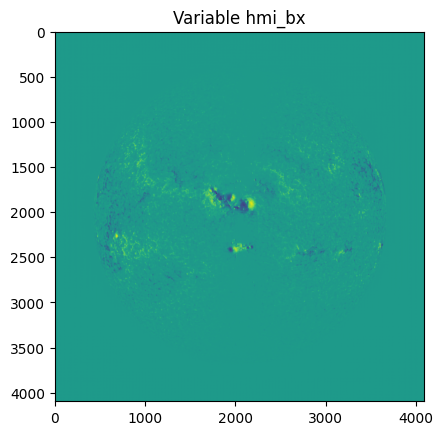

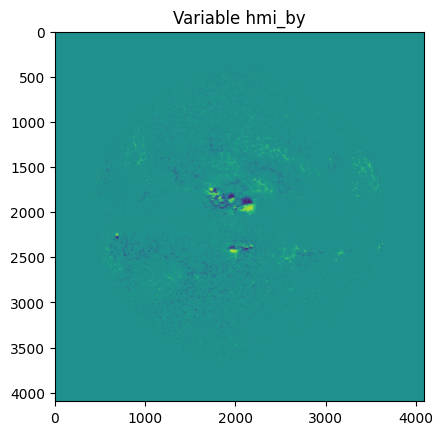

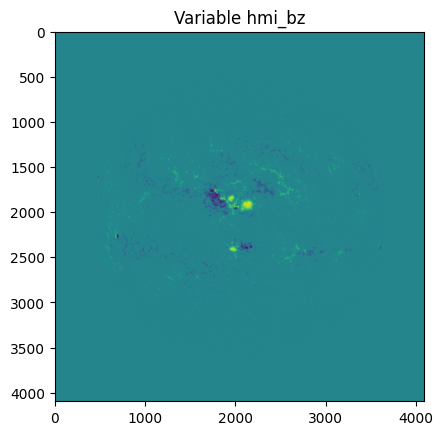

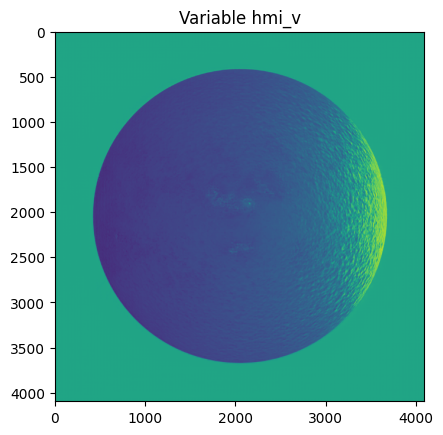

In [10]:
dset = prediction[0]

dset = dset.cpu().float().numpy().astype("float32")

for channel in range(dset.shape[1]):
   plt.figure(channel)    
   plt.title(f"Variable {channels[channel]}")
   plt.imshow(dset[0, channel, ...])
